In [1]:
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
from sklearn import feature_selection as fs
from sklearn import metrics, cross_validation
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math
import matplotlib as mpl
%matplotlib inline

/Users/fathielshibani/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
## Eliminate low variance features
#The VarianceThreshold function from the scikit-learn feature_selection package 
#identifies features with less than some threshold of unique values.

In [3]:
Features = np.array(pd.read_csv('Features.csv'))
Labels = np.array(pd.read_csv('Labels.csv'))
print(Features.shape)
print(Labels.shape)

(71517, 177)
(71517, 1)


In [4]:
print(Features.shape)

## Define the variance threhold and fit the threshold to the feature array. 
sel = fs.VarianceThreshold(threshold=(.8 * (1 - .8)))
Features_reduced = sel.fit_transform(Features)

## Print the support and shape for the transformed features
print(sel.get_support())
print(Features_reduced.shape)

(71517, 177)
[False False  True False False  True  True False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True  True False False False False False False False
 False False False False False  True  True  True  True False False  True
  True False  True False False False False False False False False  True
 False False False False False False  True False  True False False False
 False False False  True False False  

In [5]:
## Select k best features(cross validation method)
#### The RFECV function from the scikit-learn feature_selection package is used to determine which features to retain using a cross validation method.
#### Notice that AUC is used as the model selection metric as the labels are imbalanced. In this case, the default, accuracy is a poor choice.

## Reshape the Label array
Labels = Labels.reshape(Labels.shape[0],)

## Set folds for nested cross validation
nr.seed(988)
feature_folds = ms.KFold(n_splits=10, shuffle = True)

## Define the model
logistic_mod = linear_model.LogisticRegression(C = 10, class_weight = {0:0.45, 1:0.55}) 

## Perform feature selection by CV with high variance features only
nr.seed(6677)
selector = fs.RFECV(estimator = logistic_mod, cv = feature_folds,
                      scoring = 'roc_auc')
selector = selector.fit(Features_reduced, Labels)
selector.support_ 

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True, False, False,  True, False, False, False, False,
        True,  True,  True], dtype=bool)

In [6]:
selector.ranking_

array([ 9,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  6,
       10,  1,  1,  4,  5,  1,  3,  2,  8,  7,  1,  1,  1])

In [7]:
Features_reduced = selector.transform(Features_reduced)
Features_reduced.shape

(71517, 21)

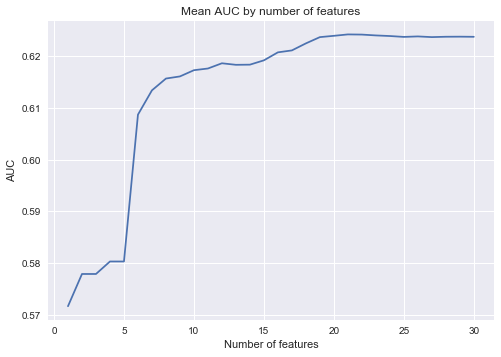

In [13]:
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.title('Mean AUC by number of features')
plt.ylabel('AUC')
plt.xlabel('Number of features')
mpl.style.use("seaborn")

In [9]:
np.savetxt(r'Features_Reduced.csv',Features_reduced,delimiter=',')

In [10]:
## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features_reduced.shape[0])
indx = ms.train_test_split(indx, test_size = 10000)
X_train = Features_reduced[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features_reduced[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

## Define and fit the logistic regression model
logistic_mod = linear_model.LogisticRegression(C = 1, class_weight = {0:0.45, 1:0.55}) 
logistic_mod.fit(X_train, y_train)

LogisticRegression(C=1, class_weight={0: 0.45, 1: 0.55}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [11]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

probabilities = logistic_mod.predict_proba(X_test)
print(probabilities[:15,:])
scores = score_model(probabilities, 0.3)

[[ 0.88476071  0.11523929]
 [ 0.93379106  0.06620894]
 [ 0.93761324  0.06238676]
 [ 0.86803407  0.13196593]
 [ 0.92650556  0.07349444]
 [ 0.85069396  0.14930604]
 [ 0.91751286  0.08248714]
 [ 0.91128725  0.08871275]
 [ 0.86836393  0.13163607]
 [ 0.92227255  0.07772745]
 [ 0.90124387  0.09875613]
 [ 0.88308711  0.11691289]
 [ 0.85705379  0.14294621]
 [ 0.93872275  0.06127725]
 [ 0.92558591  0.07441409]]


                 Confusion matrix
                 Score positive    Score negative
Actual positive      9078                52
Actual negative       850                20

Accuracy        0.91
AUC             0.63
Macro precision 0.60
Macro recall    0.51
 
           Positive      Negative
Num case     9130           870
Precision    0.91          0.28
Recall       0.99          0.02
F1           0.95          0.04


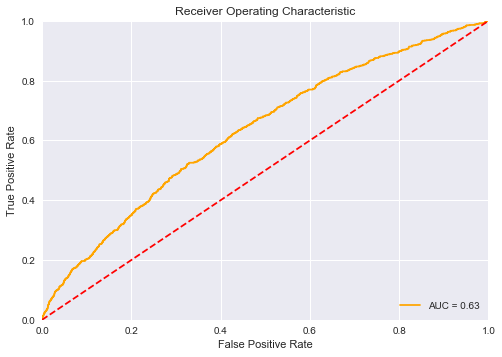

In [12]:
def print_metrics(labels, probs, threshold):
    scores = score_model(probs, threshold)
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, probs[:,1]))
    print('Macro precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()    
        
print_metrics(y_test, probabilities, 0.3)    
plot_auc(y_test, probabilities) 